# Loan Approval Classification: Model Tuning, Selection & Evaluation

**Project:** Data Science/ML Practice  
**Objective:** Compare, tune, and evaluate two tree-based classification models (Random Forest and Gradient Boosting) for loan approval prediction. Save the best-performing model for deployment.

## 1. Load and Prepare Data

Load the cleaned data from Notebook 1. Identify numeric and categorical features. Set up the target variable.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load cleaned data
data = pd.read_csv('data/loanApproval/cleanLoanApprovalData.csv')

# Set target and features
target_col = 'loan_status'
X = data.drop(columns=target_col)
y = data[target_col].astype(int)  # Convert bool to int for sklearn compatibility

# Identify feature types
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=[np.number, 'bool']).columns.tolist()

print(f"Categorical features: {categorical_features}")
print(f"Numeric features: {numeric_features}")

Categorical features: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Numeric features: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']


## 2. Train/Test Split
Purpose: Split data so model evaluation is honest and stratified.

In [2]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 36000, Test size: 9000


## 3. Preprocessing Pipeline
One-hot encode categoricals. No scaling required for tree models.

In [3]:
# Preprocessing for tree models: only one-hot encoding for categoricals
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features)
], remainder='passthrough')

## 4. Model Pipelines and Hyperparameter Grids
Define Random Forest and Gradient Boosting models. Set up tuning grids.

In [4]:
# Define models and hyperparameter grids
models = {
    "RandomForest": {
        "estimator": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
        ]),
        "param_grid": {
            "classifier__max_features": ["sqrt", "log2"],
            "classifier__min_samples_split": [2, 5, 10]
        },
        "results": {}
    },
    "GradientBoosting": {
        "estimator": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", GradientBoostingClassifier(n_estimators=200, random_state=42))
        ]),
        "param_grid": {
            "classifier__max_features": ["sqrt", "log2"],
            "classifier__min_samples_split": [2, 5, 10]
        },
        "results": {}
    }
}

# Stratified cross-validation for imbalanced data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 5. Model Training, Tuning, Evaluation
Train models with cross-validation, tune parameters, and evaluate.

In [5]:
def train_and_evaluate(model_name, model_dict, X_train, X_test, y_train, y_test, categorical_features):
    """Train and evaluate a model, storing metrics and best params."""
    print(f"\n==== {model_name} ====")
    grid = GridSearchCV(model_dict["estimator"], model_dict["param_grid"], cv=cv, scoring="roc_auc", n_jobs=-1, return_train_score=True)
    grid.fit(X_train, y_train)
    model_dict["grid"] = grid
    model_dict["results"]["best_params"] = grid.best_params_
    model_dict["results"]["best_cv_auc"] = grid.best_score_
    print("Best params:", grid.best_params_)
    print("Best CV ROC-AUC:", grid.best_score_)
    
    # Test set evaluation
    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:,1]
    model_dict["results"]["test_auc"] = roc_auc_score(y_test, y_proba)
    model_dict["results"]["test_accuracy"] = accuracy_score(y_test, y_pred)
    model_dict["results"]["test_precision"] = precision_score(y_test, y_pred)
    model_dict["results"]["test_recall"] = recall_score(y_test, y_pred)
    model_dict["results"]["test_f1"] = f1_score(y_test, y_pred)
    model_dict["results"]["confusion_matrix"] = confusion_matrix(y_test, y_pred)
    print("Test set AUC:", model_dict["results"]["test_auc"])
    
    # Cross-validated AUCs for visualization
    model_dict["results"]["cv_aucs"] = cross_val_score(grid.best_estimator_, X_train, y_train, cv=cv, scoring="roc_auc")
    print("Cross-validated AUCs:", model_dict["results"]["cv_aucs"])
    
    # Feature importance (Random Forest/Gradient Boosting)
    importances = grid.best_estimator_.named_steps['classifier'].feature_importances_
    ohe = grid.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(categorical_features) if categorical_features else []
    all_feature_names = list(cat_names) + [col for col in X_train.columns if col not in categorical_features]
    importance_df = pd.DataFrame({"feature": all_feature_names, "importance": importances})
    importance_df = importance_df.sort_values('importance', ascending=False)
    print("\nTop Features by importance:\n", importance_df.head(10))
    model_dict["results"]["feature_importance"] = importance_df
    return model_dict

## 6. Train and Evaluate Both Models

In [6]:
for name in models:
    train_and_evaluate(
        name,
        models[name],
        X_train,
        X_test,
        y_train,
        y_test,
        categorical_features
    )


==== RandomForest ====
Best params: {'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 2}
Best CV ROC-AUC: 0.9729975892857142
Test set AUC: 0.974614642857143
Cross-validated AUCs: [0.97238242 0.96947695 0.97566535 0.97272734 0.97473588]

Top Features by importance:
                                feature  importance
17   previous_loan_defaults_on_file_no    0.204885
18  previous_loan_defaults_on_file_yes    0.199090
23                       loan_int_rate    0.124370
24                 loan_percent_income    0.105986
20                       person_income    0.088615
22                           loan_amnt    0.045251
26                        credit_score    0.044193
19                          person_age    0.025732
10          person_home_ownership_rent    0.024574
21                      person_emp_exp    0.023396

==== GradientBoosting ====
Best params: {'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 2}
Best CV ROC-AUC: 0.9720955468749999
Te

## 7. Model Comparison: Visualize ROC and CV AUCs

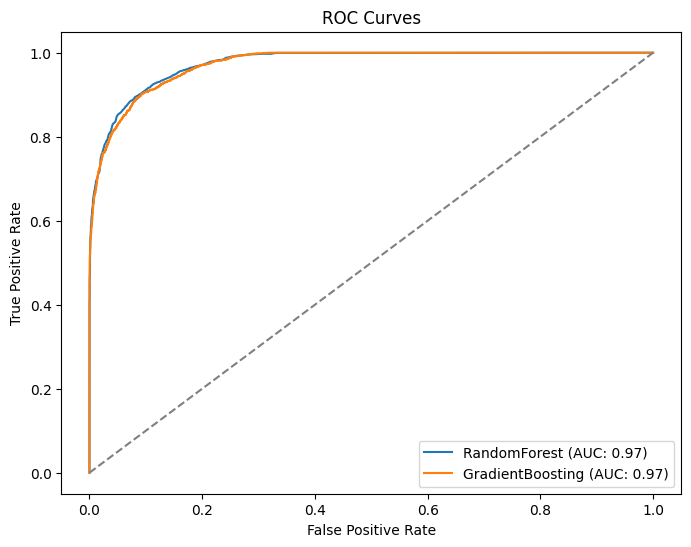

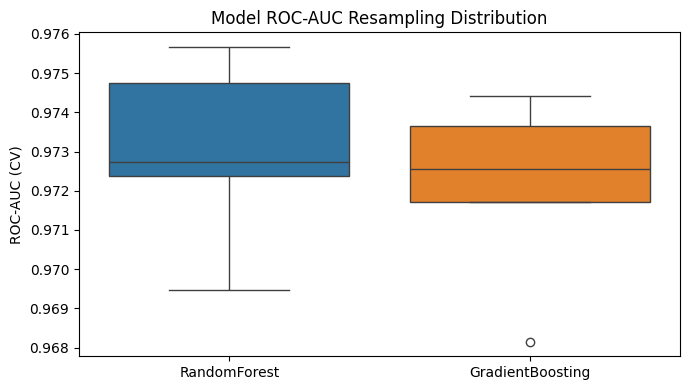

In [7]:
# ROC curves for both models
plt.figure(figsize=(8,6))
for name, model in models.items():
    grid = model["grid"]
    y_proba = grid.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC: {auc:.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

# Boxplot of CV AUCs
cv_auc_dict = {name: model["results"]["cv_aucs"] for name, model in models.items() if "cv_aucs" in model["results"]}
cv_auc_df = pd.DataFrame(cv_auc_dict)
plt.figure(figsize=(7,4))
sns.boxplot(data=cv_auc_df)
plt.ylabel("ROC-AUC (CV)")
plt.title("Model ROC-AUC Resampling Distribution")
plt.tight_layout()
plt.show()

## 8. Summary Table: Model Metrics

In [8]:
metrics = []
for name, model in models.items():
    r = model["results"]
    metrics.append({
        "Model": name,
        "Test AUC": r["test_auc"],
        "Accuracy": r["test_accuracy"],
        "Precision": r["test_precision"],
        "Recall": r["test_recall"],
        "F1": r["test_f1"]
    })
summary = pd.DataFrame(metrics)
print("\nModel Performance Metrics:\n", summary)


Model Performance Metrics:
               Model  Test AUC  Accuracy  Precision  Recall        F1
0      RandomForest  0.974615  0.929667   0.902770   0.766  0.828780
1  GradientBoosting  0.972871  0.926556   0.880182   0.775  0.824249


## 9. Save the Best Model
Select and save the best-performing model (highest ROC-AUC).

In [9]:
# Select best model by test ROC-AUC
best_model_name = summary.sort_values(by='Test AUC', ascending=False).iloc[0]['Model']
best_pipeline = models[best_model_name]["grid"].best_estimator_
model_path = f'data/loanApproval/Loan_{best_model_name}_pipeline.pkl'
joblib.dump(best_pipeline, model_path)
print(f"Best model ({best_model_name}) saved to {model_path}")

Best model (RandomForest) saved to data/loanApproval/Loan_RandomForest_pipeline.pkl


## Conclusion
- Both Random Forest and Gradient Boosting models were trained, tuned and evaluated.
- The best-performing model Random Forest(by ROC-AUC) was saved for deployment.
- Feature importance and evaluation metrics can be reviewed above.

### Next Steps
- Deploy the saved model to Hugging Face or another serving platform as needed.
- Use modular code and templates for future ML projects.